In [158]:
import torch
from torch import nn,optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [159]:
with open("data/names.txt","r") as f:
    words = f.read().lower().split('\n')
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [160]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [161]:
chars = sorted(list(set(''.join(words))))
str_to_idx = {c:i+1 for i,c in enumerate(chars)}
str_to_idx['.'] = 0
idx_to_str = {i:c for c,i in str_to_idx.items()}

In [168]:
block_size = 3
embed_sz = 5
vocab_size = len(str_to_idx)

In [169]:
def build_dateset(words):
    X, Y = [],[]
    
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = str_to_idx[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    return torch.tensor(X).to(device),torch.tensor(Y).to(device)

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dateset(words[:n1])
Xdev,Ydev = build_dateset(words[n1:n2])
Xte,Yte = build_dateset(words[n2:])

# Embedding
Develop a MLP that beats NGRAM model.

In [170]:
class Emb_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Embedding(vocab_size,embed_sz),
            nn.Flatten(),
            nn.Linear(embed_sz*block_size, 200),
            nn.Tanh(),
            nn.Linear(200, vocab_size),
            # nn.Softmax()
        )
    def forward(self, x):
        logits = self.main(x)
        return logits
model = Emb_Model().to(device)

In [171]:
# optimization configurations
loss_fn = nn.CrossEntropyLoss()
epochs = 1000
max_learning_rate = 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=max_learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    cooldown=10,
    threshold=1e-3,
    mode='min'
)

In [172]:
train_lossi = []
test_lossi = []

In [173]:
for i in range(epochs):
    # forward pass
    pred = model(Xtr)
    loss = loss_fn(pred,Ytr)
    
    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    # tracing
    train_lossi.append(loss.item())
    with torch.no_grad():
        pred = model(Xte)
        loss = loss_fn(pred,Yte)
        test_lossi.append(loss.item())
    if i % 100 == 0:
        print(i,loss.item())
# 2.1701

4.094041347503662
2.4101717472076416
2.3025612831115723
2.2534027099609375
2.219417095184326
2.1946957111358643
2.179628849029541
2.179506301879883
2.179506301879883
2.179506301879883


In [174]:
with torch.no_grad():
    pred = model(Xdev)
    loss = loss_fn(pred,Ydev)
    print(loss.item())

2.171013832092285


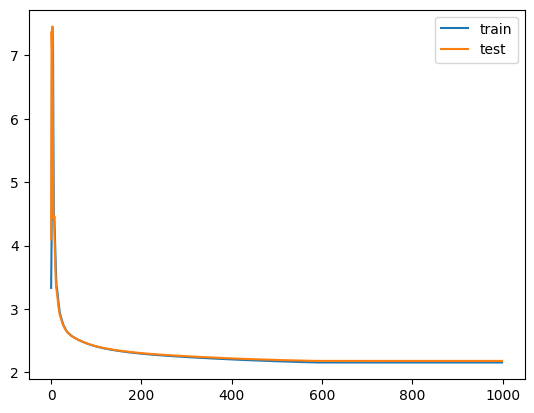

In [175]:
plt.plot(train_lossi[::],label='train')
plt.plot(test_lossi[::],label='test')
plt.legend()

In [176]:
g = torch.Generator(device).manual_seed(42)
for _ in range(5):
    out = []
    context = [0] * block_size
    while True:
        logits = model(torch.tensor(context).to(device).view(1,-1))
        ix = torch.multinomial(logits.exp(),num_samples=1,generator=g).item()
        context = context[1:] +[ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(idx_to_str[i] for i in out))

krita.
elyn.
rapee.
dagbran.
lakonie.
